/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


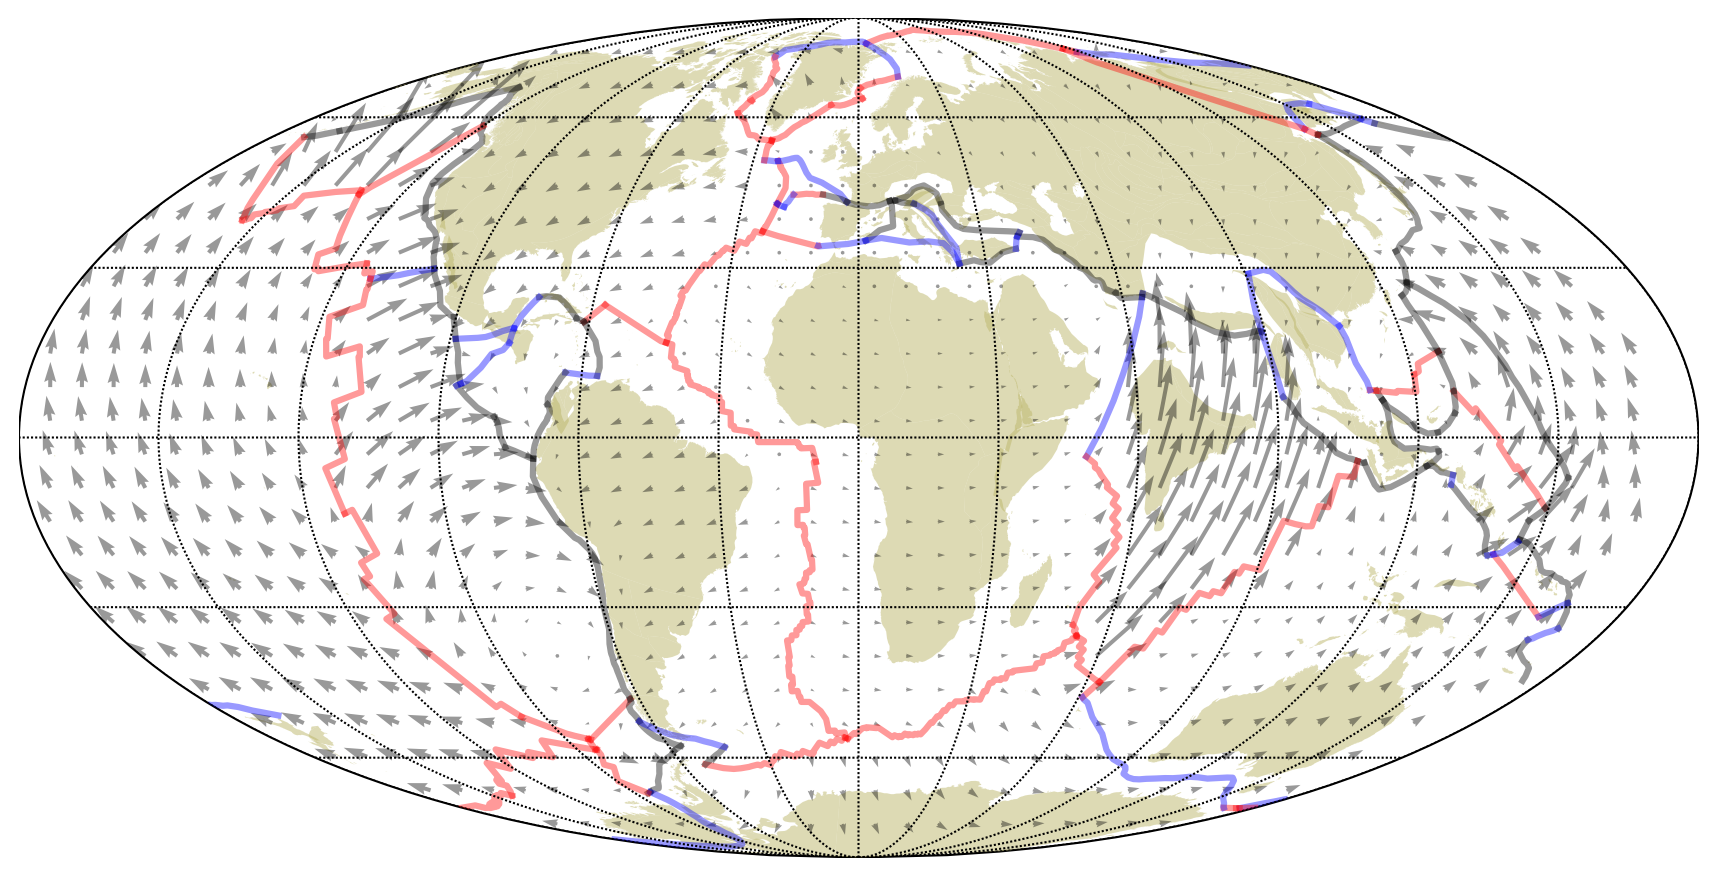

In [1]:
import pygplates
import numpy as np
import sys
sys.path.append('../libs/')
from topology_plotting import *
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from matplotlib.patches import Polygon

%matplotlib inline

rotation_filename = 'Data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
topology_features = ['Data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',\
             'Data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']

# Load one or more rotation files into a rotation model.
rotation_model = pygplates.RotationModel(rotation_filename)

time=50

coastlines_file = 'Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
pygplates.reconstruct(coastlines_file, rotation_model, 'tmp.shp', time, 1)

fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])
lon0=0
m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
#m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
cp = m.drawmapboundary()
#m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

# Plot reconstructed coastlines
shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
for nshape,seg in enumerate(m.shp):
    poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0)
    plt.gca().add_patch(poly)
        
plot_velocities_and_topologies(m,topology_features,rotation_model,time,
                               delta_time=5,res=10,scale=4000,lon0=lon0,clip_path=cp)

plt.show()


In [2]:
time_step = 2.
oldest_seed_time = 150.

# Empty array for storing Long/Lat of 
point_longitude = []
point_latitude = []


# Location of seed point for Kerguelen
hs_geometry = []
# Seed point for Kerguelen
hs_geometry.append(pygplates.PointOnSphere(-49, 69))
# Seed point for Hawaii
hs_geometry.append(pygplates.PointOnSphere(19, -155))
# Seed point for Reunion
hs_geometry.append(pygplates.PointOnSphere(-17, 59))
# Seed point for Iceland
hs_geometry.append(pygplates.PointOnSphere(64, -17))
# Seed point for Tristan
hs_geometry.append(pygplates.PointOnSphere(-37, -12))
# Seed point for Louisville
hs_geometry.append(pygplates.PointOnSphere(-54, -141))
# Seed point for Afar
hs_geometry.append(pygplates.PointOnSphere(7, 39))
# Seed point for Samoa
hs_geometry.append(pygplates.PointOnSphere(-15, -168))
# Seed point for Easter
hs_geometry.append(pygplates.PointOnSphere(-27, -110))
# Seed point for Crozet
hs_geometry.append(pygplates.PointOnSphere(-46, 50))
# Seed point for Ascension
hs_geometry.append(pygplates.PointOnSphere(-8, -14))
# Seed point for Tahiti
hs_geometry.append(pygplates.PointOnSphere(-18, -148))
# Seed point for Azores
hs_geometry.append(pygplates.PointOnSphere(38, -28))
# Seed point for Yellowstone
hs_geometry.append(pygplates.PointOnSphere(44, -111))




    
point_list = []

for time in np.arange(150,0.,-time_step):
    
    print 'working on time %d' % time
    
    for hs_point in hs_geometry:
        point_list.append(hs_point)    

    # Get the plate polygons for this time
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

    # make plate partitioner from polygons
    plate_partitioner = pygplates.PlatePartitioner(resolved_topologies, rotation_model)

    new_point_list = []
    point_longitude = []
    point_latitude = []
    for seed_geometry in point_list:
    # Find the plate id of the polygon that contains the point
        polygon = plate_partitioner.partition_point(seed_geometry)
    
        PlateID = polygon.get_feature().get_reconstruction_plate_id()
        #print PlateID

        # Get the stage rotation that will move the point from where it is at the current time
        # to its location at the next time step, based on the plate id that contains the point at the 
        # current time
        stage_rotation = rotation_model.get_rotation(time-time_step, PlateID, time, anchor_plate_id=1)

        # use the stage rotation to reconstruct the tracked point from position at current time 
        # to position at the next time step
        seed_geometry = stage_rotation * seed_geometry
    
        point_longitude.append(seed_geometry.to_lat_lon_point().get_longitude())
        point_latitude.append(seed_geometry.to_lat_lon_point().get_latitude())
        
        new_point_list.append(seed_geometry)
        
    point_list = new_point_list
        
    #### Plotting
    pygplates.reconstruct(coastlines_file, rotation_model, 'tmp.shp', time, 1)

    fig = plt.figure(figsize=(14,10),dpi=150)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    lon0=0
    m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
    #m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
    cp = m.drawmapboundary()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,30))

    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0)
        plt.gca().add_patch(poly)

    plot_velocities_and_topologies(m,topology_features,rotation_model,time,
                                   delta_time=5,res=10,scale=4000,lon0=lon0,clip_path=cp)
    
    for hs_point in hs_geometry:
        x,y = m(hs_point.to_lat_lon()[1],hs_point.to_lat_lon()[0])
        m.plot(x,y,'r*',markersize=20,zorder=1)
    
    x, y = m(point_longitude, point_latitude)
    m.plot(x,y,'.',markersize=10,zorder=1)
    
    plt.title('Time = %d Ma' % time)

    plt.savefig('plume_product_tracker_%d_Ma.png' % time)
    plt.close()
    
    

working on time 150
working on time 148
working on time 146
working on time 144
working on time 142
working on time 140
working on time 138
working on time 136
working on time 134
working on time 132
working on time 130
working on time 128
working on time 126
working on time 124
working on time 122
working on time 120
working on time 118
working on time 116
working on time 114
working on time 112
working on time 110
working on time 108
working on time 106
working on time 104
working on time 102
working on time 100
working on time 98
working on time 96
working on time 94
working on time 92
working on time 90
working on time 88
working on time 86
working on time 84
working on time 82
working on time 80
working on time 78
working on time 76
working on time 74
working on time 72
working on time 70
working on time 68
working on time 66
working on time 64
working on time 62
working on time 60
working on time 58
working on time 56
working on time 54
working on time 52
working on time 50
worki

If moviepy is available, you can try creating a gif (or other animation format) from the sequence of images generated in the above cell.

In [3]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(150,0.,-time_step):
    frame_list.append('plume_product_tracker_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('hotspot_trails.gif')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.03186688/45929032 bytes (6.9%6397952/45929032 bytes (13.97233536/45929032 bytes (15.710461184/45929032 bytes (22.8%13770752/45929032 bytes (30.0%17113088/45929032 bytes (37.3%17227776/45929032 bytes (37.5%20307968/45929032 bytes (44.2%22896640/45929032 bytes (49.9%25092096/45929032 bytes (54.6%28344320/45929032 bytes (61.7%31588352/45929032 bytes (68.8%33480704/45929032 bytes (72.9%36765696/45929032 bytes (80.0%40034304/45929032 bytes (87.2%41951232/45929032 bytes (91.3%44294144/45929032 bytes (96.4%45015040/45929032 bytes (98.0%45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]

MoviePy - Building file hotspot_trails.gif with imageio.


In [4]:
from IPython.display import Image
Image(url='./hotspot_trails.gif')